### Imports

In [5]:
import matplotlib.pyplot as plt
import librosa
from librosa import display
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from os import listdir
from os.path import isdir, exists
import h5py
from keras.utils.vis_utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings

import tensorflow as tf
np.random.seed(423)

### Helper functions

In [10]:
# function for saving models with classes
# code from https://stackoverflow.com/questions/44310448/attaching-class-labels-to-a-keras-model
def save_model_ext(model, filepath, overwrite=True, meta_data=None):
    tf.keras.models.save_model(model, filepath, overwrite)
    if meta_data is not None:
        f = h5py.File(filepath, mode='a')
        f.attrs['my_meta_data'] = meta_data
        f.close()

### Function for making visualizations using the .wav samples
def wav_to_plots(folder_name, spec=False, adsr=True, subfolders=True):
    '''
        Takes a folder name and creates spectrograms and/or amplitude plots
        for the .wav files in that folder.

        folder_name: where the .wav files are, and where the plots will be placed.
        spec: bool indicating whether or not to make spectrograms
        adsr: bool indicating whether or not to make amplitude plots
        subfolders: bool indicating if the wav/spectrogram/adsr folders have subfolders
    '''
    # paths to different files
    wav_path = f'../audio_files/mono/{folder_name}/wavs'
    spec_path = f'../audio_files/mono/{folder_name}/spectrograms'
    adsr_path = f'../audio_files/mono/{folder_name}/adsr_plots'

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # portion of code for when subfolders are included
        if (subfolders == True): # if a folder with subfolders
            for subfolder in listdir(wav_path):
                if isdir(f'{wav_path}/{subfolder}'): # if given filepath is actually a subfolder
                    for w in listdir(f'{wav_path}/{subfolder}'):
                        w_name = w.split('.')[0]
                        # check if spectrogram exists already
                        if exists(f'{adsr_path}/{subfolder}/{w_name}') == False:
                            # spectrograms
                            try:
                                if (spec):
                                    # read wavefile
                                    sample_rate, samples = wavfile.read(f'{wav_path}/{subfolder}/{w}')
                                    with plt.ioff():
                                        # code from https://stackoverflow.com/questions/44165411/most-efficient-way-to-generate-many-figures-with-matplotlib
                                        fig = plt.Figure()
                                        ax = fig.add_subplot(111)
                                        ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256, mode='default')
                                        ax.axis('off')
                                        canvas = FigureCanvas(fig)
                                        canvas.print_figure(f'{spec_path}/{subfolder}/{w}.png', bbox_inches='tight')
                                if (adsr): # adsr plot
                                    audio_sample = librosa.load(f'{wav_path}/{subfolder}/{w}')
                            
                                    with plt.ioff():
                                        fig = plt.Figure()
                                        ax = fig.add_subplot(111)
                                        ax.plot(audio_sample[0])
                                        ax.axis('off')
                                        canvas = FigureCanvas(fig)
                                        w_name = w.split('.')[0]
                                        canvas.print_figure(f'{adsr_path}/{subfolder}_{w_name}.png', bbox_inches='tight')
                            except: # catches the .DS_Store files
                                print(f'Error with file at {wav_path}/{subfolder}/{w}')
        # when no subfolders are included
        else:
            for w in listdir(wav_path):
                w_name = w.split('.')[0]
                # print(f'{spec_path}/{subfolder}/{w_name}')
                # check if spectrogram exists already
                if exists(f'{adsr_path}/{w_name}.png') == False:
                    # spectrograms
                    try:
                        if (spec): # spectrogram
                            sample_rate, samples = wavfile.read(f'{wav_path}/{w}')
                            with plt.ioff():
                                fig = plt.Figure()
                                ax = fig.add_subplot(111)
                                ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256, mode='default')
                                ax.axis('off')
                                canvas = FigureCanvas(fig)
                                canvas.print_figure(f'{spec_path}/{w_name}.png', bbox_inches='tight')
                        if (adsr): # adsr plot
                            audio_sample = librosa.load(f'{wav_path}/{w}')
                    
                            with plt.ioff():
                                fig = plt.Figure()
                                ax = fig.add_subplot(111)
                                ax.plot(audio_sample[0])
                                ax.axis('off')
                                canvas = FigureCanvas(fig)
                                canvas.print_figure(f'{adsr_path}/{w_name}.png', bbox_inches='tight')
                    except: # catches the .DS_Store files
                        print(f'Error with file at {wav_path}/{w}')



## Modeling - Estimating Attack, Decay, Sustain, Release (ADSR) Durations

Data from Group 3 - Multiple Waveforms in One Sample (3_mult_waves_detune_adsr)

In [13]:
group_folder_name = '3_mult_waves_detune_adsr'

In [14]:
# wav_to_plots(folder_name=group_folder_name, spec=False, subfolders=False)

In [15]:
data1 = pd.read_csv('../audio_files/mono/3_mult_waves_detune_adsr/file_data1-1500.csv')
data2 = pd.read_csv('../audio_files/mono/3_mult_waves_detune_adsr/file_data1501-2000.csv')

data = pd.concat([data1, data2], axis=0, ignore_index=True)

data.drop('Unnamed: 0', axis=1, inplace=True)
data['file_name'] = data['file_name'] + '.png'
data

,file_name,sine_wave,sine_freq,square_wave,square_freq,saw_wave,saw_freq,triangle_wave,triangle_freq,note,octave,note_octave,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
0,multi_G♯6_1.png,1,1638.838913,1,1640.307018,1,1656.804422,1,1664.158678,G♯,6,G♯6,1.267070,2.232218,0.370960,3.718841,0.610021
1,multi_D2_2.png,0,0.000000,0,0.000000,0,0.000000,1,73.258947,D,2,D2,1.374754,4.620323,0.962909,3.338172,0.666750
2,multi_G♯7_3.png,0,0.000000,0,0.000000,0,0.000000,1,3372.876338,G♯,7,G♯7,2.682675,2.672962,0.086228,1.643651,3.000712
3,multi_A2_4.png,0,0.000000,0,0.000000,0,0.000000,1,111.483137,A,2,A2,0.787984,0.806069,0.285842,1.712964,2.360331
4,multi_G♯7_5.png,1,3368.208180,1,3329.405194,1,3349.358188,1,3291.964996,G♯,7,G♯7,1.523768,2.817253,0.917175,2.985630,2.673349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,multi_D♯6_1996.png,0,0.000000,0,0.000000,0,0.000000,1,1223.180842,D♯,6,D♯6,3.379760,2.552351,0.684349,1.313016,2.754873
1996,multi_E6_1997.png,1,1300.862275,1,1311.209106,1,1297.087466,1,1315.534690,E,6,E6,3.391882,1.006275,0.428023,1.687678,3.914166
1997,multi_G♯1_1998.png,0,0.000000,0,0.000000,1,52.556835,1,50.920170,G♯,1,G♯1,0.306900,0.901301,0.586998,3.325771,4.641430
1998,multi_D♯7_1999.png,0,0.000000,0,0.000000,1,2491.996780,0,0.000000,D♯,7,D♯7,2.663929,3.241306,0.563076,1.900169,2.194596


In [16]:
data.describe()

,sine_wave,sine_freq,square_wave,square_freq,saw_wave,saw_freq,triangle_wave,triangle_freq,octave,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.633000,1604.682472,0.646500,1704.190916,0.611500,1569.205345,0.617500,1568.400507,4.977500,2.231430,2.244687,0.502475,2.177515,2.238192
std,0.482107,3182.531154,0.478176,3244.449265,0.487531,3168.621228,0.486119,3086.992558,2.615227,1.245197,1.217839,0.286306,1.234093,1.225963
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.004533,0.000895,0.000079,0.000871,0.013774
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.226247,1.249472,0.258770,1.186451,1.276770
50%,1.000000,106.825070,1.000000,121.988522,1.000000,88.354431,1.000000,97.314975,5.000000,2.272329,2.304316,0.507313,2.196969,2.265038
75%,1.000000,1377.985986,1.000000,1555.286153,1.000000,1258.916666,1.000000,1325.178830,7.000000,3.214371,3.163580,0.750814,3.127564,3.153628
max,1.000000,16100.177493,1.000000,16002.126058,1.000000,15969.414288,1.000000,15957.736543,9.000000,4.999849,4.997394,0.999693,4.979601,4.986292


### CNN Model - ADSR Durations

In [26]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255.)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

y_cols = ['attack_duration', 'decay_duration', 'sustain_duration', 'release_duration']

train_gen = datagen.flow_from_dataframe(
    data[:1750],
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='training',
    shuffle='False'
)

val_gen = datagen.flow_from_dataframe(
    data[:1750],
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='validation',
    shuffle='False'
)

test_gen = test_datagen.flow_from_dataframe(
    data[1750:],
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32
)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

model3_2_durations = Sequential()

model3_2_durations.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model3_2_durations.add(MaxPooling2D(pool_size=(4,4)))

model3_2_durations.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model3_2_durations.add(MaxPooling2D(pool_size=(4,4)))

model3_2_durations.add(Flatten())
model3_2_durations.add(Dense(35, activation='relu'))
model3_2_durations.add(Dense(4, activation='relu'))

es = EarlyStopping(
    monitor = 'val_mse',
    verbose = 1,
    mode='min',
    patience=7
)

mc = ModelCheckpoint(
    filepath='../models/model3.2_durationsmc{epoch:02d}-val_mse{val_mse:.2f}',
    monitor='val_mse',
    mode='min',
    save_best_only=True,
    initial_value_threshold=.5
)

model3_2_durations.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mse', 'mae']
)

history3_2_durations = model3_2_durations.fit(
    train_gen,
    validation_data=val_gen,
    # y=y_cols,
    # y=
    epochs=100,
    callbacks=[es, mc])

# model3_2.summary()

Found 1400 validated image filenames.
Found 350 validated image filenames.
Found 250 validated image filenames.
Epoch 1/100
44/44 [==============================] - 76s 2s/step - loss: 1.8513 - mse: 1.8513 - mae: 1.1098 - val_loss: 1.4076 - val_mse: 1.4076 - val_mae: 0.9874
Epoch 2/100
44/44 [==============================] - 75s 2s/step - loss: 1.3438 - mse: 1.3438 - mae: 0.9537 - val_loss: 1.2284 - val_mse: 1.2284 - val_mae: 0.9084
Epoch 3/100
44/44 [==============================] - 75s 2s/step - loss: 1.0918 - mse: 1.0918 - mae: 0.8412 - val_loss: 1.0955 - val_mse: 1.0955 - val_mae: 0.8278
Epoch 4/100
44/44 [==============================] - 77s 2s/step - loss: 0.9352 - mse: 0.9352 - mae: 0.7581 - val_loss: 0.9725 - val_mse: 0.9725 - val_mae: 0.7686
Epoch 5/100
44/44 [==============================] - 78s 2s/step - loss: 0.8889 - mse: 0.8889 - mae: 0.7329 - val_loss: 0.9261 - val_mse: 0.9261 - val_mae: 0.7457
Epoch 6/100
44/44 [==============================] - 78s 2s/step - loss: 

2022-06-12 12:53:16.903109: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/model3.2_durationsmc31-val_mse0.50/assets
44/44 [==============================] - 79s 2s/step - loss: 0.3128 - mse: 0.3128 - mae: 0.3958 - val_loss: 0.4976 - val_mse: 0.4976 - val_mae: 0.4929
Epoch 32/100
44/44 [==============================] - 80s 2s/step - loss: 0.2976 - mse: 0.2976 - mae: 0.3824 - val_loss: 0.5158 - val_mse: 0.5158 - val_mae: 0.4962
Epoch 33/100
44/44 [==============================] - 79s 2s/step - loss: 0.2849 - mse: 0.2849 - mae: 0.3764 - val_loss: 0.5072 - val_mse: 0.5072 - val_mae: 0.5012
Epoch 34/100
44/44 [==============================] - 79s 2s/step - loss: 0.2756 - mse: 0.2756 - mae: 0.3709 - val_loss: 0.5301 - val_mse: 0.5301 - val_mae: 0.5194
Epoch 35/100
44/44 [==============================] - 79s 2s/step - loss: 0.2777 - mse: 0.2777 - mae: 0.3723 - val_loss: 0.5093 - val_mse: 0.5093 - val_mae: 0.4979
Epoch 36/100
44/44 [==============================] - 78s 2s/step - loss: 0.2579 - mse: 0.2579 - mae: 0.35

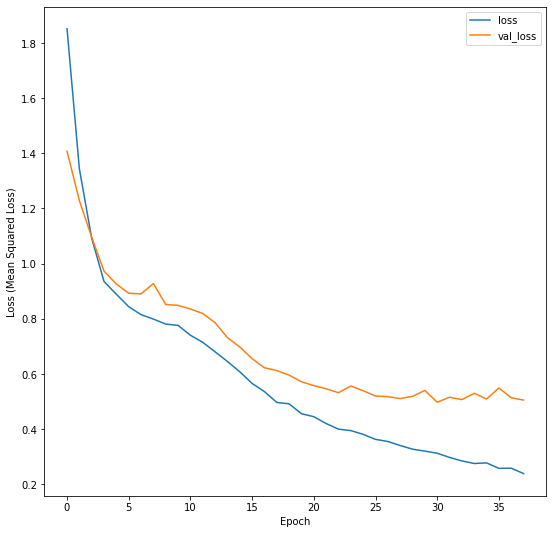

In [31]:
plt.figure(figsize=(9,9))
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Loss)')
plt.plot(history3_2_durations.history['loss'])
plt.plot(history3_2_durations.history['val_loss'])
plt.legend(['loss', 'val_loss']);

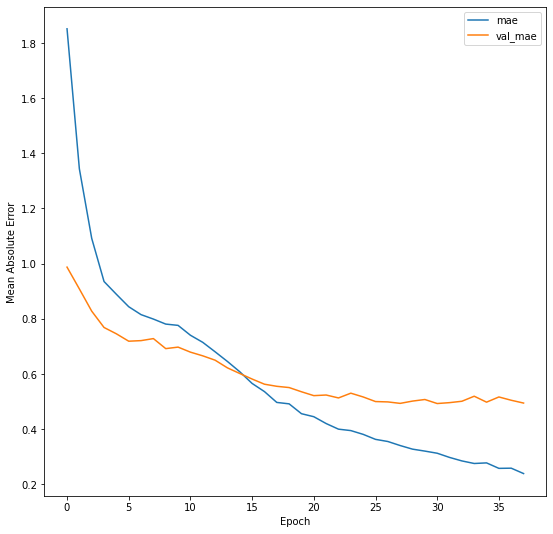

In [32]:
plt.figure(figsize=(9,9))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.plot(history3_2_durations.history['mse'])
plt.plot(history3_2_durations.history['val_mae'])
plt.legend(['mae', 'val_mae']);

#### Durations model for Streamlit

Metrics on test set:
- Mean squared error: 0.3838
- Mean absolute error: 0.4360

In [ ]:
model3_2_durations.evaluate(test_gen)

8/8 [==============================] - 2s 210ms/step - loss: 0.3838 - mse: 0.3838 - mae: 0.4360


[0.3838055431842804, 0.3838055431842804, 0.4360448122024536]

In [ ]:
model3_2_durations.save('../models/model3.2_durationstest_mse0.383')

INFO:tensorflow:Assets written to: ../models/model3.2_durationstest_mse0.383/assets


### CNN Model - Sustain Level

In [48]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1./255.)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

y_cols = 'sustain_level'

train_gen = datagen.flow_from_dataframe(
    data[:1750],
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='training',
    shuffle='False'
)

val_gen = datagen.flow_from_dataframe(
    data[:1750],
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='validation',
    shuffle='False'
)

test_gen = test_datagen.flow_from_dataframe(
    data[1750:],
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32
)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

model3_2_s_lvl = Sequential()

model3_2_s_lvl.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model3_2_s_lvl.add(MaxPooling2D(pool_size=(4,4)))

model3_2_s_lvl.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model3_2_s_lvl.add(MaxPooling2D(pool_size=(4,4)))

model3_2_s_lvl.add(Flatten())
model3_2_s_lvl.add(Dense(35, activation='relu'))
model3_2_s_lvl.add(Dense(1))

es = EarlyStopping(
    monitor = 'val_mae',
    verbose = 1,
    mode='min',
    patience=5
)

mc = ModelCheckpoint(
    filepath='../models/model3.2_s_lvlmc{epoch:02d}-val_mae{val_mae:.2f}',
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    initial_value_threshold=.5
)

model3_2_s_lvl.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=[
        'mse',
        'mae',
        tf.keras.metrics.RootMeanSquaredError(name='rmse')
    ]
)

history3_2_s_lvl = model3_2_s_lvl.fit(
    train_gen,
    validation_data=val_gen,
    # y=y_cols,
    # y=
    epochs=100,
    callbacks=[es, mc])

# model3_2.summary()

Found 1488 validated image filenames.
Found 262 validated image filenames.
Found 250 validated image filenames.
Epoch 1/100
47/47 [==============================] - 82s 2s/step - loss: 0.3714 - mse: 0.7892 - mae: 0.3714 - rmse: 0.8884 - val_loss: 0.1623 - val_mse: 0.0393 - val_mae: 0.1623 - val_rmse: 0.1982
Epoch 2/100
47/47 [==============================] - 81s 2s/step - loss: 0.1498 - mse: 0.0389 - mae: 0.1498 - rmse: 0.1972 - val_loss: 0.1289 - val_mse: 0.0317 - val_mae: 0.1289 - val_rmse: 0.1781
Epoch 3/100
47/47 [==============================] - 82s 2s/step - loss: 0.1197 - mse: 0.0277 - mae: 0.1197 - rmse: 0.1664 - val_loss: 0.1210 - val_mse: 0.0291 - val_mae: 0.1210 - val_rmse: 0.1705
Epoch 4/100
47/47 [==============================] - 83s 2s/step - loss: 0.1069 - mse: 0.0241 - mae: 0.1069 - rmse: 0.1552 - val_loss: 0.1050 - val_mse: 0.0227 - val_mae: 0.1050 - val_rmse: 0.1506
Epoch 5/100
47/47 [==============================] - 82s 2s/step - loss: 0.1051 - mse: 0.0232 - mae:

In [49]:
model3_2_s_lvl.evaluate(test_gen)

8/8 [==============================] - 2s 201ms/step - loss: 0.0554 - mse: 0.0087 - mae: 0.0554 - rmse: 0.0931


[0.0554078184068203,
 0.008669407106935978,
 0.0554078184068203,
 0.09310965240001678]

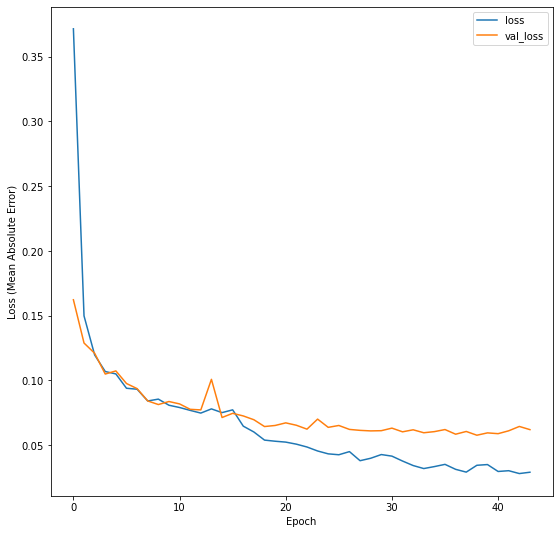

In [56]:
plt.figure(figsize=(9,9))
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Absolute Error)')
plt.plot(history3_2_s_lvl.history['loss'])
plt.plot(history3_2_s_lvl.history['val_loss'])
plt.legend(['loss', 'val_loss']);

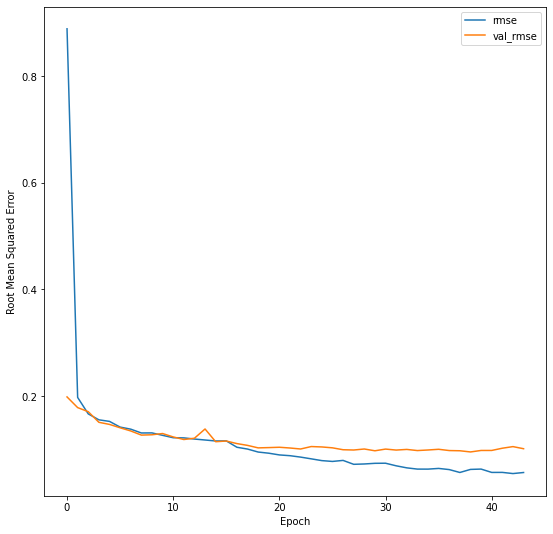

In [57]:
plt.figure(figsize=(9,9))
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.plot(history3_2_s_lvl.history['rmse'])
plt.plot(history3_2_s_lvl.history['val_rmse'])
plt.legend(['rmse', 'val_rmse']);

### Sustain model for Streamlit

Metrics on test set:
- Mean squared error: 0.0082
- Mean absolute error: 0.0552
- Root mean absolute error: 0.0904

In [ ]:
model3_2_s_lvl_loaded = tf.keras.models.load_model('../models/model3.2_s_lvlmc39-val_mae0.06')
model3_2_s_lvl_loaded.evaluate(test_gen)

8/8 [==============================] - 2s 200ms/step - loss: 0.0552 - mse: 0.0082 - mae: 0.0552 - rmse: 0.0904


[0.055229153484106064,
 0.008178310468792915,
 0.055229153484106064,
 0.0904340147972107]